# Imports 

In [14]:
# basic
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# feature transformation and pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# model selection and crossvalidation
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFECV
from genetic_selection import GeneticSelectionCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV  # glmnet equivalent l1 and l2 regularization
from sklearn.linear_model import HuberRegressor # outliers robust
from sklearn.linear_model import RidgeCV
# non linear
from sklearn.tree import DecisionTreeRegressor

# ensemble 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

# metrics for regression
from sklearn.metrics import max_error,mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_squared_log_error,median_absolute_error,r2_score
from sklearn.metrics import make_scorer
from sklearn import metrics

# Model Tunning Evaluations
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

# Utilities
from sklearn import set_config
import time

# Load Data Divide 

In [15]:
# Loading and Doing Basics
df= pd.read_csv('test_volume_data.csv',parse_dates=['date'])
df["date"] = pd.to_datetime(df["date"])
df.head()
df['min_commit'].fillna(0,inplace=True)
df['Day_of_week'] = pd.to_datetime(df['date']).dt.day_name()
df['Year'] = pd.to_datetime(df['date']).dt.year
df['Month'] = pd.to_datetime(df['date']).dt.month
DF_test= df[df['date'] > '2021-02-28' ]
df= df[df['date'] <= '2021-02-28' ]
# reason we divided data on basis of date to mimic real life predictions
# we took one month of data for prediction as generally retrain of model 
# happens monthly

# Feature Transformation Pipeline 

In [26]:
num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']
cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']


In [3]:
# we can use below pipeline for final basic model but we generaly use other methods 
# to fine tune and build complex models
# We could have written customer function to get output of scores into a dataframe or csv
# for model comparisions

num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']
cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']

outcome=df['volume_tests']
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error',drop='first'))
])
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor)
])

pipe.fit(df, outcome)
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['company_type',
                                                   'number_test_types',
                                                   'is_testing', 'Day_of_week',
                                                   'Year', 'Month']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['avg_pesq_score',
                                                   'quality_too_poor',
                                                   'number_busy',
                                                   'temporarily_unable_test',
                                                   'outage_sec',
                                                   'numbers_tested',
                                                   'followup_tests',
                                                   'min_commit'])]))])

# Feature Transformation Without Pipeline

In [16]:
# Feature transformation without pipeline
cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']
for col in cat_cols:
    df[col] = df[col].astype(str) 
df[cat_cols]=df[cat_cols].apply(lambda x: x.str.strip())

for col in cat_cols:
    dummies=pd.get_dummies(df[col],prefix=col,drop_first=True)
    df[dummies.columns]=dummies
df=df.drop(cat_cols,axis=1)
num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']
scaler = StandardScaler()
df[num_cols] = scaler.fit(df[num_cols]).transform(df[num_cols])



# Feature Selection Estimator Validation With Linear Model As Base

>lr 0.992 (0.002)
>cart 0.989 (0.001)
>rf 0.993 (0.002)
>gbm 0.988 (0.002)


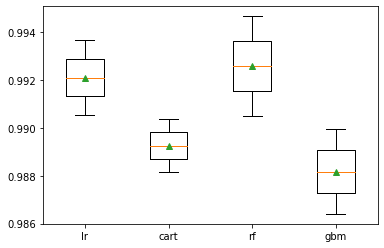

In [83]:
predictors=['avg_pesq_score', 'quality_too_poor','number_busy', 'temporarily_unable_test', 'outage_sec',
            'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit','company_type_Conference','company_type_Enterprise', 'number_test_types_1', 'number_test_types_2',
            'number_test_types_3', 'number_test_types_4', 'number_test_types_5','number_test_types_6',
            'is_testing_1', 'Day_of_week_Monday','Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
            'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Year_2019','Year_2020', 'Year_2021', 'Month_10', 'Month_11',
            'Month_12', 'Month_2','Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8','Month_9']

x_train=df[predictors].to_numpy()
y_train=df['volume_tests'].to_numpy()
# generally we use repeat 3 and splits 10 
# we will use no repeat and 5 splits 
# we have huge data my machine can't handle :)

def get_models():
    
    models = dict()
    # lr
    rfe = RFECV(estimator=LinearRegression())
    model = DecisionTreeRegressor()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFECV(estimator=DecisionTreeRegressor())
    model = DecisionTreeRegressor()
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFECV(estimator=RandomForestRegressor())
    model = DecisionTreeRegressor()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFECV(estimator=GradientBoostingRegressor())
    model = DecisionTreeRegressor()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=1)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model,x_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# Recursive Fetaure Elimination Code

In [9]:
predictors=['avg_pesq_score', 'quality_too_poor','number_busy', 'temporarily_unable_test', 'outage_sec',
            'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit','company_type_Conference','company_type_Enterprise', 'number_test_types_1', 'number_test_types_2',
            'number_test_types_3', 'number_test_types_4', 'number_test_types_5','number_test_types_6',
            'is_testing_1', 'Day_of_week_Monday','Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
            'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Year_2019','Year_2020', 'Year_2021', 'Month_10', 'Month_11',
            'Month_12', 'Month_2','Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8','Month_9']

x_train=df[predictors].to_numpy()
y_train=df['volume_tests'].to_numpy()
# Pick Features which are best suited based on R2 score
rfe = RFECV(estimator=RandomForestRegressor())
# fit RFE
rfe.fit(x_train, y_train)
# summarize all features
for i in range(x_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected False, Rank: 6.000
Column: 3, Selected False, Rank: 8.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 4.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected False, Rank: 5.000
Column: 11, Selected False, Rank: 18.000
Column: 12, Selected False, Rank: 11.000
Column: 13, Selected False, Rank: 7.000
Column: 14, Selected False, Rank: 2.000
Column: 15, Selected False, Rank: 21.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected False, Rank: 30.000
Column: 18, Selected False, Rank: 25.000
Column: 19, Selected False, Rank: 14.000
Column: 20, Selected False, Rank: 13.000
Column: 21, Selected False, Rank: 28.000
Column: 22, Selected False, Rank: 27.000
Column: 23, Selected False, Rank: 29.000
Column: 24, Selected True, Rank: 1.000
Column: 2

In [ ]:
# 9 rank 1 features are there :
#'avg_pesq_score', 'quality_too_poor', 'outage_sec',
#'numbers_tested', 'followup_tests', 'min_commit',
#'company_type_Conference','number_test_types_6',
#'Year_2019'=> these features are clearly top features selected by other method also
# as year 2019 is included it might be a issue for future prediction 

# Genetic Feature Selection Code

In [17]:
# demonstration purpose only
estimator = RandomForestRegressor()

selector = GeneticSelectionCV(estimator,cv=2,verbose=1,scoring="r2",max_features=10,
                              n_population=50,crossover_proba=0.5,mutation_proba=0.2,
                              n_generations=40,crossover_independent_proba=0.5,
                              mutation_independent_proba=0.05,tournament_size=3,
                              n_gen_no_change=10,caching=True,n_jobs=-1)

selector = selector.fit(x_train, y_train)

print(selector.support_)

Selecting features with genetic algorithm.
gen	nevals	avg                    	std                    	min                      	max                      
0  	50    	[0.26461602 5.64      ]	[0.43056747 2.96486087]	[-0.41268499  1.        ]	[ 0.90080223 10.        ]
1  	27    	[-1199.40356388     7.52      ]	[3.24983562e+03 2.75855034e+00]	[-1.e+04  2.e+00]        	[ 0.90080223 14.        ]
2  	36    	[-599.20770901    7.42      ]  	[2.37506859e+03 2.33315237e+00]	[-1.e+04  2.e+00]        	[ 0.90080223 13.        ]
3  	25    	[-799.20365692    7.72      ]  	[2.71316682e+03 2.35830448e+00]	[-1.e+04  3.e+00]        	[ 0.90080223 14.        ]
4  	37    	[-1399.24215447     8.48      ]	[3.47017609e+03 1.95181966e+00]	[-1.e+04  4.e+00]        	[ 0.90080223 12.        ]
5  	31    	[-599.16505505    8.26      ]  	[2.37507936e+03 1.74137876e+00]	[-1.e+04  4.e+00]        	[ 0.91548114 12.        ]
6  	41    	[-1799.26789771     8.42      ]	[3.84221755e+03 1.96051014e+00]	[-1.e+04  4.e+00]        

KeyboardInterrupt: 

In [ ]:
# my system could run it fully 

# Base Cross Validated Models


In [11]:
# pick inbuild Metric
print(metrics.SCORERS.keys())
# 
Final_Results=list()
Model_Names=list()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

# Linear Regression Base Line Cross validated

In [5]:
# we will try to use three scoring method
# R2 , mean absolute Error , mean squared error

scoring = {
    'r2': "r2",
    'mean_absolute_error': make_scorer(mean_absolute_error),
    'mean_squared_error': make_scorer(mean_squared_error)}

num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']

cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']

outcome=df['volume_tests']
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error',drop='first'))
])
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
   ('model', LinearRegression())
])

# default 5 : generally we do 10 splits with 5 repeats

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_validate(pipe, df, outcome, scoring=scoring, cv=cv, n_jobs=-1,
                        return_train_score=True)

Final_Results.append(scores)
Model_Names.append('LinearRegression')

print('Mean R2 Score  : ', np.round(np.mean(scores['test_r2']),3))
print('Std of R2 Score: ', np.round(np.std(scores['test_r2']),3))
print()
print('Losses lower the better')
print()
print('Mean of Root Mean Squared loss:  ', np.round(np.sqrt(np.mean(scores['test_mean_squared_error'])),3))
print('Std of Root Mean Squared loss:   ',np.round(np.sqrt(np.std(scores['test_mean_squared_error'])),3))
print()
print('Mean of Mean Abs loss:   ',np.round(np.mean(scores['test_mean_absolute_error']),3))
print('Std of Mean Abs loss:    ',np.round(np.std(scores['test_mean_absolute_error']),3))

Mean R2 Score  :  0.924
Std of R2 Score:  0.006

Losses lower the better

Mean of Root Mean Squared loss:   1138.338
Std of Root Mean Squared loss:    230.887

Mean of Mean Abs loss:    434.289
Std of Mean Abs loss:     5.759


# Elastic Net Base Line Cross validated

In [6]:
# we will try to use three scoring method
# R2 , mean absolute Error , mean squared error

scorers = {
    'r2': "r2",
    'mean_absolute_error': make_scorer(mean_absolute_error),
    'mean_squared_error': make_scorer(mean_squared_error)}

num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']

cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']

outcome=df['volume_tests']
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error',drop='first'))
])
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
   ('model', ElasticNetCV())
])

# default 5 : generally we do 10 splits with 5 repeats

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_validate(pipe, df, outcome, scoring=scoring, cv=cv, n_jobs=-1,
                        return_train_score=True)

Final_Results.append(scores)
Model_Names.append('ElasticNetCV')

print('Mean R2 Score  : ', np.round(np.mean(scores['test_r2']),3))
print('Std of R2 Score: ', np.round(np.std(scores['test_r2']),3))
print()
print('Losses lower the better')
print()
print('Mean of Root Mean Squared loss:  ', np.round(np.sqrt(np.mean(scores['test_mean_squared_error'])),3))
print('Std of Root Mean Squared loss:   ',np.round(np.sqrt(np.std(scores['test_mean_squared_error'])),3))
print()
print('Mean of Mean Abs loss:   ',np.round(np.mean(scores['test_mean_absolute_error']),3))
print('Std of Mean Abs loss:    ',np.round(np.std(scores['test_mean_absolute_error']),3))

Mean R2 Score  :  0.585
Std of R2 Score:  0.005

Losses lower the better

Mean of Root Mean Squared loss:   2664.158
Std of Root Mean Squared loss:    853.548

Mean of Mean Abs loss:    684.637
Std of Mean Abs loss:     19.404


# Hubberised LR Base Line Cross Validated

In [7]:
# we will try to use three scoring method
# R2 , mean absolute Error , mean squared error

scorers = {
    'r2': "r2",
    'mean_absolute_error': make_scorer(mean_absolute_error),
    'mean_squared_error': make_scorer(mean_squared_error)}

num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']

cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']

outcome=df['volume_tests']
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error',drop='first'))
])
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
   ('model', HuberRegressor())
])

# default 5 : generally we do 10 splits with 5 repeats

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_validate(pipe, df, outcome, scoring=scoring, cv=cv, n_jobs=-1,
                        return_train_score=True)

Final_Results.append(scores)
Model_Names.append('HuberRegressor')

print('Mean R2 Score  : ', np.round(np.mean(scores['test_r2']),3))
print('Std of R2 Score: ', np.round(np.std(scores['test_r2']),3))
print()
print('Losses lower the better')
print()
print('Mean of Root Mean Squared loss:  ', np.round(np.sqrt(np.mean(scores['test_mean_squared_error'])),3))
print('Std of Root Mean Squared loss:   ',np.round(np.sqrt(np.std(scores['test_mean_squared_error'])),3))
print()
print('Mean of Mean Abs loss:   ',np.round(np.mean(scores['test_mean_absolute_error']),3))
print('Std of Mean Abs loss:    ',np.round(np.std(scores['test_mean_absolute_error']),3))

Mean R2 Score  :  0.88
Std of R2 Score:  0.007

Losses lower the better

Mean of Root Mean Squared loss:   1433.834
Std of Root Mean Squared loss:    439.045

Mean of Mean Abs loss:    349.239
Std of Mean Abs loss:     10.606


# Ensemble Methods Non Linears

# Random Forest Base Line Cross Validated

In [8]:
# we will try to use three scoring method
# R2 , mean absolute Error , mean squared error

scorers = {
    'r2': "r2",
    'mean_absolute_error': make_scorer(mean_absolute_error),
    'mean_squared_error': make_scorer(mean_squared_error)}

num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']

cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']

outcome=df['volume_tests']
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error',drop='first'))
])
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
   ('model', RandomForestRegressor())
])

# default 5 : generally we do 10 splits with 5 repeats

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_validate(pipe, df, outcome, scoring=scoring, cv=cv, n_jobs=-1,
                       return_train_score=True)

Final_Results.append(scores)
Model_Names.append('RandomForestRegressor')

print('Mean R2 Score  : ', np.round(np.mean(scores['test_r2']),3))
print('Std of R2 Score: ', np.round(np.std(scores['test_r2']),3))
print()
print('Losses lower the better')
print()
print('Mean of Root Mean Squared loss:  ', np.round(np.sqrt(np.mean(scores['test_mean_squared_error'])),3))
print('Std of Root Mean Squared loss:   ',np.round(np.sqrt(np.std(scores['test_mean_squared_error'])),3))
print()
print('Mean of Mean Abs loss:   ',np.round(np.mean(scores['test_mean_absolute_error']),3))
print('Std of Mean Abs loss:    ',np.round(np.std(scores['test_mean_absolute_error']),3))

Mean R2 Score  :  0.997
Std of R2 Score:  0.003

Losses lower the better

Mean of Root Mean Squared loss:   236.561
Std of Root Mean Squared loss:    196.248

Mean of Mean Abs loss:    38.48
Std of Mean Abs loss:     1.804


# Extra Regressor Base Line Cross Validated

In [9]:
# we will try to use three scoring method
# R2 , mean absolute Error , mean squared error

scorers = {
    'r2': "r2",
    'mean_absolute_error': make_scorer(mean_absolute_error),
    'mean_squared_error': make_scorer(mean_squared_error)}

num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']

cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']

outcome=df['volume_tests']
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error',drop='first'))
])
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
   ('model', ExtraTreesRegressor())
])

# default 5 : generally we do 10 splits with 5 repeats

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_validate(pipe, df, outcome, scoring=scoring, cv=cv, n_jobs=-1,
                        return_train_score=True)

Final_Results.append(scores)
Model_Names.append('ExtraTreesRegressor')

print('Mean R2 Score  : ', np.round(np.mean(scores['test_r2']),3))
print('Std of R2 Score: ', np.round(np.std(scores['test_r2']),3))
print()
print('Losses lower the better')
print()
print('Mean of Root Mean Squared loss:  ', np.round(np.sqrt(np.mean(scores['test_mean_squared_error'])),3))
print('Std of Root Mean Squared loss:   ',np.round(np.sqrt(np.std(scores['test_mean_squared_error'])),3))
print()
print('Mean of Mean Abs loss:   ',np.round(np.mean(scores['test_mean_absolute_error']),3))
print('Std of Mean Abs loss:    ',np.round(np.std(scores['test_mean_absolute_error']),3))

Mean R2 Score  :  0.998
Std of R2 Score:  0.001

Losses lower the better

Mean of Root Mean Squared loss:   196.783
Std of Root Mean Squared loss:    141.664

Mean of Mean Abs loss:    35.775
Std of Mean Abs loss:     1.57


# AdaBoosted Base Line Cross Validated

In [10]:
# we will try to use three scoring method
# R2 , mean absolute Error , mean squared error

scorers = {
    'r2': "r2",
    'mean_absolute_error': make_scorer(mean_absolute_error),
    'mean_squared_error': make_scorer(mean_squared_error)}

num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']

cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']

outcome=df['volume_tests']
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error',drop='first'))
])
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
   ('model', AdaBoostRegressor())
])

# default 5 : generally we do 10 splits with 5 repeats

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_validate(pipe, df, outcome, scoring=scoring, cv=cv, n_jobs=-1,
                        return_train_score=True)

Final_Results.append(scores)
Model_Names.append('AdaBoostRegressor')

print('Mean R2 Score  : ', np.round(np.mean(scores['test_r2']),3))
print('Std of R2 Score: ', np.round(np.std(scores['test_r2']),3))
print()
print('Losses lower the better')
print()
print('Mean of Root Mean Squared loss:  ', np.round(np.sqrt(np.mean(scores['test_mean_squared_error'])),3))
print('Std of Root Mean Squared loss:   ',np.round(np.sqrt(np.std(scores['test_mean_squared_error'])),3))
print()
print('Mean of Mean Abs loss:   ',np.round(np.mean(scores['test_mean_absolute_error']),3))
print('Std of Mean Abs loss:    ',np.round(np.std(scores['test_mean_absolute_error']),3))

Mean R2 Score  :  0.512
Std of R2 Score:  0.192

Losses lower the better

Mean of Root Mean Squared loss:   2842.098
Std of Root Mean Squared loss:    1599.258

Mean of Mean Abs loss:    2686.786
Std of Mean Abs loss:     469.328


# Gradient Boost Sklearn Version Base cross validated

In [11]:
# we will try to use three scoring method
# R2 , mean absolute Error , mean squared error

scorers = {
    'r2': "r2",
    'mean_absolute_error': make_scorer(mean_absolute_error),
    'mean_squared_error': make_scorer(mean_squared_error)}

num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']

cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']

outcome=df['volume_tests']
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error',drop='first'))
])
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
   ('model', GradientBoostingRegressor())
])

# default 5 : generally we do 10 splits with 5 repeats

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_validate(pipe, df, outcome, scoring=scoring, cv=cv, n_jobs=-1,
                        return_train_score=True)

Final_Results.append(scores)
Model_Names.append('GradientBoostingRegressor')

print('Mean R2 Score  : ', np.round(np.mean(scores['test_r2']),3))
print('Std of R2 Score: ', np.round(np.std(scores['test_r2']),3))
print()
print('Losses lower the better')
print()
print('Mean of Root Mean Squared loss:  ', np.round(np.sqrt(np.mean(scores['test_mean_squared_error'])),3))
print('Std of Root Mean Squared loss:   ',np.round(np.sqrt(np.std(scores['test_mean_squared_error'])),3))
print()
print('Mean of Mean Abs loss:   ',np.round(np.mean(scores['test_mean_absolute_error']),3))
print('Std of Mean Abs loss:    ',np.round(np.std(scores['test_mean_absolute_error']),3))

Mean R2 Score  :  0.989
Std of R2 Score:  0.003

Losses lower the better

Mean of Root Mean Squared loss:   437.534
Std of Root Mean Squared loss:    184.772

Mean of Mean Abs loss:    157.656
Std of Mean Abs loss:     3.159


# Histogram Gradient boost (sklearn version Inspired by LightGBM) base cross validated

In [12]:
# we will try to use three scoring method
# R2 , mean absolute Error , mean squared error

scorers = {
    'r2': "r2",
    'mean_absolute_error': make_scorer(mean_absolute_error),
    'mean_squared_error': make_scorer(mean_squared_error)}

num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']

cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']

outcome=df['volume_tests']
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error',drop='first'))
])
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
   ('model', HistGradientBoostingRegressor())
])

# default 5 : generally we do 10 splits with 5 repeats

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_validate(pipe, df, outcome, scoring=scoring, cv=cv, n_jobs=-1,
                        return_train_score=True)

Final_Results.append(scores)
Model_Names.append('HistGradientBoostingRegressor')

print('Mean R2 Score  : ', np.round(np.mean(scores['test_r2']),3))
print('Std of R2 Score: ', np.round(np.std(scores['test_r2']),3))
print()
print('Losses lower the better')
print()
print('Mean of Root Mean Squared loss:  ', np.round(np.sqrt(np.mean(scores['test_mean_squared_error'])),3))
print('Std of Root Mean Squared loss:   ',np.round(np.sqrt(np.std(scores['test_mean_squared_error'])),3))
print()
print('Mean of Mean Abs loss:   ',np.round(np.mean(scores['test_mean_absolute_error']),3))
print('Std of Mean Abs loss:    ',np.round(np.std(scores['test_mean_absolute_error']),3))

Mean R2 Score  :  0.994
Std of R2 Score:  0.002

Losses lower the better

Mean of Root Mean Squared loss:   324.781
Std of Root Mean Squared loss:    154.985

Mean of Mean Abs loss:    93.514
Std of Mean Abs loss:     2.263


# Base Model Evaluation

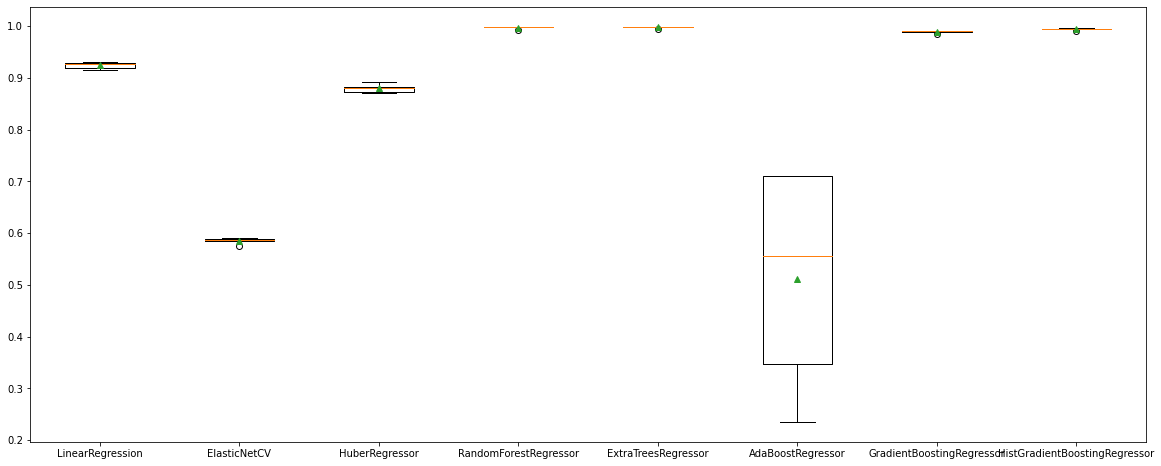

In [47]:
score=list()
for i in range(len(Final_Results)):
    score.append(Final_Results[i]['test_r2'])
plt.figure(figsize=(20,8))
plt.boxplot(score, labels=Model_Names, showmeans=True)
plt.show()

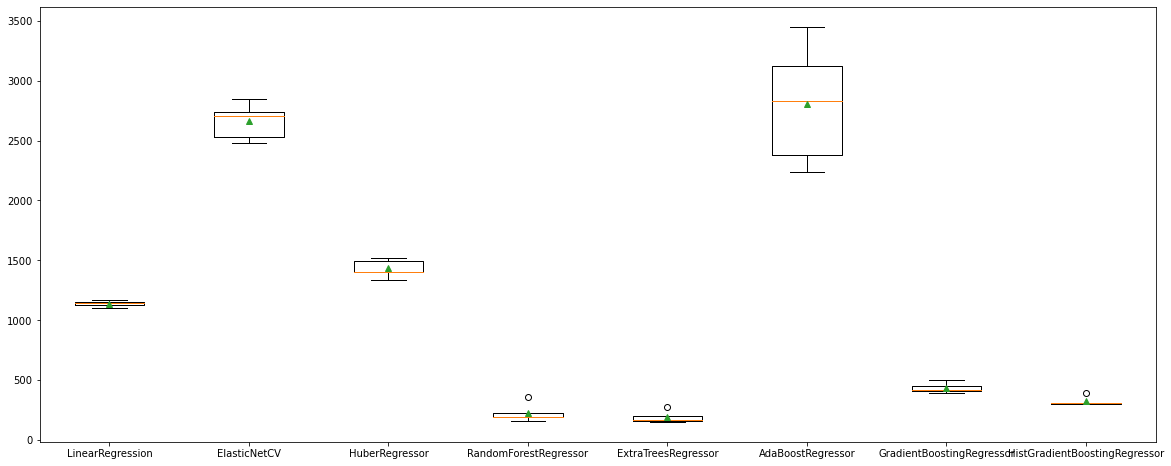

In [48]:
score=list()
for i in range(len(Final_Results)):
    score.append(np.sqrt(Final_Results[i]['test_mean_squared_error']))
plt.figure(figsize=(20,8))
plt.boxplot(score, labels=Model_Names, showmeans=True)
plt.show()

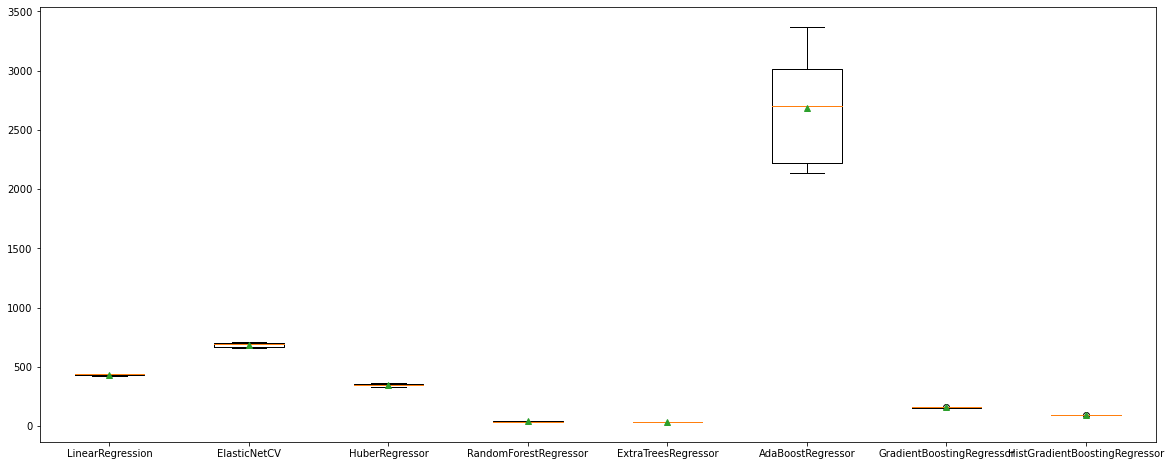

In [49]:
score=list()
for i in range(len(Final_Results)):
    score.append(Final_Results[i]['test_mean_absolute_error'])
plt.figure(figsize=(20,8))
plt.boxplot(score, labels=Model_Names, showmeans=True)
plt.show()

In [50]:
# Random Forest, Extra Trees , Gradientboost and Histgradientboost are the top scorers

    # From here we can go multiple ways and can be a
    # Combinatorial explosion we will pick 2 models and tune them
    # We can try xgboost , catboost and lightgbm also
    # But i dont think so its neccesary we are getting 
    # Overfit in test in all top three models
    
    # Other Things to be Consider
    # We could have compared feature importance and used them to find further cohorts
    # We could have even confirmed out findings done in eda regarding interactions
    # As Non Linear ensemble techniques take interaction into considerations
    # We could have even displayed outofbag scores or permutation scores
    # We have could have tried PCA , PLS (partial least squares) to identify features
    # We could have even try Clustering and take features as input
    # Seprate cluster analysis would have been required using silhoute's score or 
    # David Bouldin's score 
    # We could have written function to try all scores with different feature 
    # Transformation , previous eda we discovered Log , yea-johnson were good 
    # We could have tried quantile or even bucketize the numeric features 

# Learning Curve Code

In [18]:
# code from sklearn.org 
# not my code 
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


# LR And Huber Regression Curves

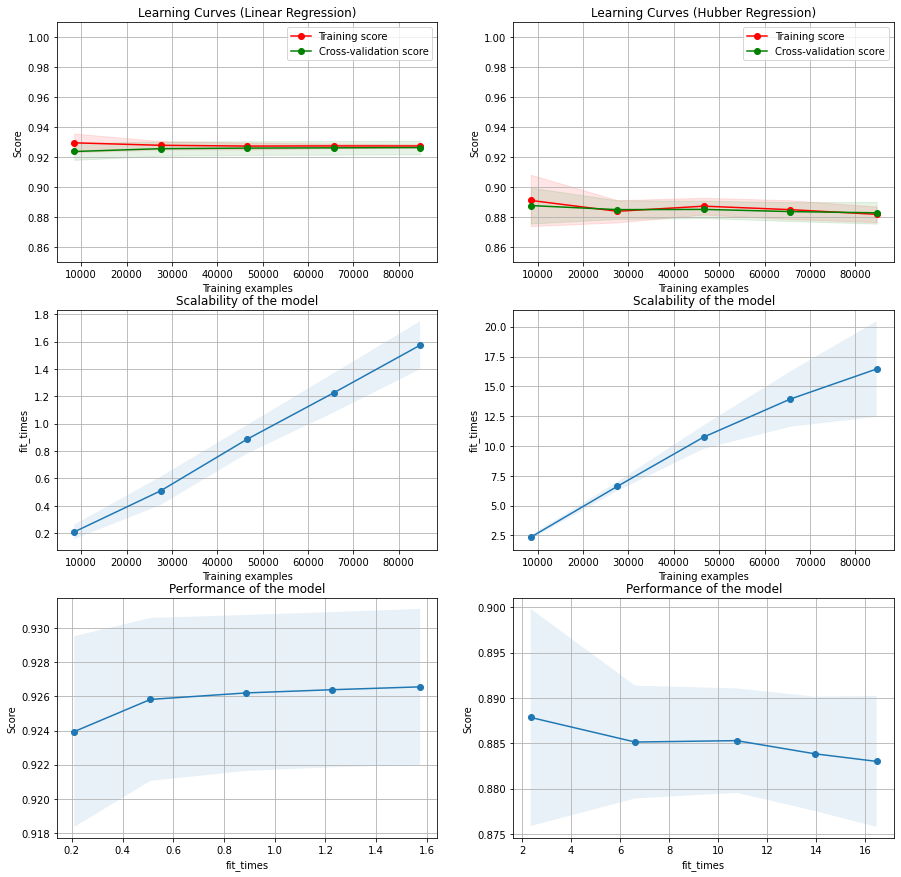

In [80]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

predictors=['avg_pesq_score', 'quality_too_poor','number_busy', 'temporarily_unable_test', 'outage_sec',
            'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit','company_type_Conference','company_type_Enterprise', 'number_test_types_1', 'number_test_types_2',
            'number_test_types_3', 'number_test_types_4', 'number_test_types_5','number_test_types_6',
            'is_testing_1', 'Day_of_week_Monday','Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
            'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Year_2019','Year_2020', 'Year_2021', 'Month_10', 'Month_11',
            'Month_12', 'Month_2','Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8','Month_9']

x_train=df[predictors].to_numpy()
y_train=df['volume_tests'].to_numpy()

title = "Learning Curves (Linear Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LinearRegression()
plot_learning_curve(
    estimator, title, x_train, y_train, axes=axes[:, 0], ylim=(0.85, 1.01), cv=cv, n_jobs=-1
)

title = r"Learning Curves (Hubber Regression)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = HuberRegressor()
plot_learning_curve(
    estimator, title, x_train, y_train, axes=axes[:, 1], ylim=(0.85, 1.01), cv=cv, n_jobs=-1
)

plt.show()

In [ ]:
#We can see clearly that the training score is still around the maximum and 
#the validation score is also similar we dont need more data we have enough. 

#The plots in the second row show the times required by the models to train with
#various sizes of training dataset as data increases more time is required. 

#The plots in the third row show how much time was required to train the models
#for each training sizes .

# Randomforest and GradientBoost Curve

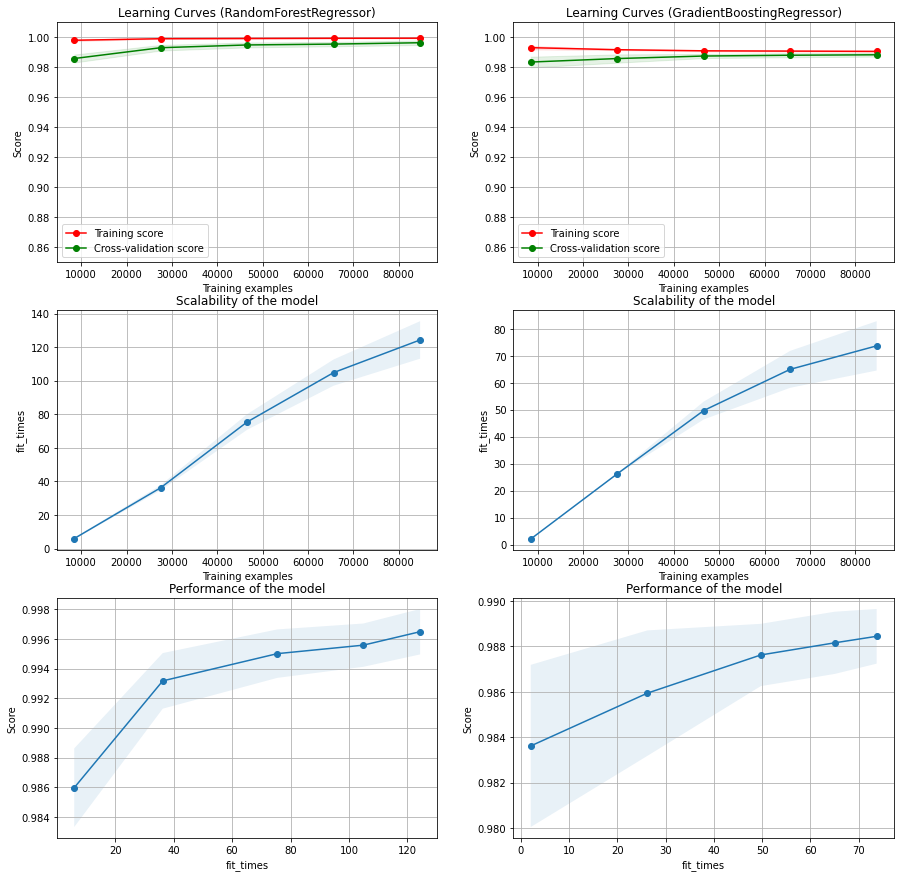

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

predictors=['avg_pesq_score', 'quality_too_poor','number_busy', 'temporarily_unable_test', 'outage_sec',
            'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit','company_type_Conference','company_type_Enterprise', 'number_test_types_1', 'number_test_types_2',
            'number_test_types_3', 'number_test_types_4', 'number_test_types_5','number_test_types_6',
            'is_testing_1', 'Day_of_week_Monday','Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
            'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Year_2019','Year_2020', 'Year_2021', 'Month_10', 'Month_11',
            'Month_12', 'Month_2','Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8','Month_9']

x_train=df[predictors].to_numpy()
y_train=df['volume_tests'].to_numpy()

title = "Learning Curves (RandomForestRegressor)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = RandomForestRegressor()
plot_learning_curve(
    estimator, title, x_train, y_train, axes=axes[:, 0], ylim=(0.85, 1.01), cv=cv, n_jobs=-1
)

title = r"Learning Curves (GradientBoostingRegressor)"
# more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = GradientBoostingRegressor()
plot_learning_curve(
    estimator, title, x_train, y_train, axes=axes[:, 1], ylim=(0.85, 1.01), cv=cv, n_jobs=-1
)

plt.show()

In [ ]:
# Both are pretty good , gradient boost is slightly better in all the three cases

# Hyper Parameter Tuning 

# Randomized Search Cv Randomforest 

In [4]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 5,num=5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)


{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [1, 2, 3, 4, 5, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2]}


In [13]:
predictors=['avg_pesq_score', 'quality_too_poor','number_busy', 'temporarily_unable_test', 'outage_sec',
            'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit','company_type_Conference','company_type_Enterprise', 'number_test_types_1', 'number_test_types_2',
            'number_test_types_3', 'number_test_types_4', 'number_test_types_5','number_test_types_6',
            'is_testing_1', 'Day_of_week_Monday','Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
            'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Year_2019','Year_2020', 'Year_2021', 'Month_10', 'Month_11',
            'Month_12', 'Month_2','Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8','Month_9']

x_train=df[predictors].to_numpy()
y_train=df['volume_tests'].to_numpy()
scorers = {
    'r2': "r2",
    'mean_absolute_error': make_scorer(mean_absolute_error),
    'mean_squared_error': make_scorer(mean_squared_error)}

rf = RandomForestRegressor()
# Random search of parameters, using 2 fold cross validation, 
# search across 10 different combinations, and use all available cores
# My system is not that good i can generally use 500 iterations and 10 cv
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1,scoring='r2',)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='r2', verbose=2)

In [33]:
# we can push min_sample_split to more values and get check if it choosed bigger value
# but we have chosen only 20 fits which is not that good 
print('best estimator values: ', rf_random.best_params_)
print()
print()
grid_s=pd.DataFrame(rf_random.cv_results_)
print('mean score and std : ')
grid_s[(grid_s['rank_test_score']==1)][['mean_test_score','std_test_score']]


# Base score was better than this 
#base estimator  "best-first fashion"
# n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2,
#min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
#max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, 
#oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False,
#ccp_alpha=0.0, max_samples=None

best estimator values:  {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


mean score and std : 


,mean_test_score,std_test_score
2,0.914118,0.013915


# HalfGridSearch Cv Randomforest

In [37]:
predictors=['avg_pesq_score', 'quality_too_poor','number_busy', 'temporarily_unable_test', 'outage_sec',
            'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit','company_type_Conference','company_type_Enterprise', 'number_test_types_1', 'number_test_types_2',
            'number_test_types_3', 'number_test_types_4', 'number_test_types_5','number_test_types_6',
            'is_testing_1', 'Day_of_week_Monday','Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
            'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Year_2019','Year_2020', 'Year_2021', 'Month_10', 'Month_11',
            'Month_12', 'Month_2','Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8','Month_9']

x_train=df[predictors].to_numpy()
y_train=df['volume_tests'].to_numpy()


rf = RandomForestRegressor()
# Random search of parameters, using 2 fold cross validation, 
# search across 500 different combinations, and use all available cores
random_gri = {'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [1, 2, 3, 4, 5, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2]}
sh = HalvingGridSearchCV(rf, random_gri, cv=2,factor=2, resource='n_estimators',max_resources=30,scoring='r2').fit(x_train, y_train)


In [39]:
print('best estimator values: ', sh.best_params_)
print()
print()
grid_s=pd.DataFrame(sh.cv_results_)
print('mean score and std : ')
grid_s[(grid_s['rank_test_score']==1)][['mean_test_score','std_test_score']]

best estimator values:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 16}


mean score and std : 


,mean_test_score,std_test_score
206,0.922297,0.025075


# Skopt GpMinimize RandomForest

In [4]:
 # my sklearn version is old
# will values have changed ['squared_error','absolute_error'] but older version 
# we still use ['mse','mae']
# define the space of hyperparameters to search
search_space = list()
search_space.append(Categorical(['mse','mae'], name='criterion'))
search_space.append(Categorical(['sqrt','log2'], name='max_features'))
search_space.append(Integer(100, 500, name='n_estimators'))
search_space.append(Integer(2, 5, name='min_samples_split'))
search_space.append(Integer(1, 5, name='min_samples_leaf'))
search_space

[Categorical(categories=('mse', 'mae'), prior=None),
 Categorical(categories=('sqrt', 'log2'), prior=None),
 Integer(low=100, high=500, prior='uniform', transform='identity'),
 Integer(low=2, high=5, prior='uniform', transform='identity'),
 Integer(low=1, high=5, prior='uniform', transform='identity')]

In [51]:
# define the function used to evaluate a given configuration
predictors=['avg_pesq_score', 'quality_too_poor','number_busy', 'temporarily_unable_test', 'outage_sec',
            'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit','company_type_Conference','company_type_Enterprise', 'number_test_types_1', 'number_test_types_2',
            'number_test_types_3', 'number_test_types_4', 'number_test_types_5','number_test_types_6',
            'is_testing_1', 'Day_of_week_Monday','Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
            'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Year_2019','Year_2020', 'Year_2021', 'Month_10', 'Month_11',
            'Month_12', 'Month_2','Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8','Month_9']

x_train=df[predictors].to_numpy()
y_train=df['volume_tests'].to_numpy()

@use_named_args(search_space)
def evaluate_model(**params):
    
    #configure the model with specific hyperparameters
    model = RandomForestRegressor()
    model.set_params(**params)
    #define test harness
    cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=1)
    #calculate 5-fold cross validation
    result = cross_val_score(model,x_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
    #calculate the mean of the scores
    estimate = np.mean(result)
    #convert from a maximizing score to a minimizing score
    return 1.0 - estimate

# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: %s' % (result.x))

In [ ]:
# Above code my machine could'nt handle just leaving the code there

# Bayes Search Cv RandomForest

In [ ]:
# define search space
params = dict()
params['min_samples_leaf'] = Integer(1,5)
params['min_samples_split'] = Integer(2,5)
#params['n_estimators'] = Integer(100,120)
params['criterion'] = Categorical(['mse','mae'])
params['max_features'] = Categorical(['sqrt','log2'])

predictors=['avg_pesq_score', 'quality_too_poor','number_busy', 'temporarily_unable_test', 'outage_sec',
            'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit','company_type_Conference','company_type_Enterprise', 'number_test_types_1', 'number_test_types_2',
            'number_test_types_3', 'number_test_types_4', 'number_test_types_5','number_test_types_6',
            'is_testing_1', 'Day_of_week_Monday','Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
            'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Year_2019','Year_2020', 'Year_2021', 'Month_10', 'Month_11',
            'Month_12', 'Month_2','Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8','Month_9']

x_train=df[predictors].to_numpy()
y_train=df['volume_tests'].to_numpy()


# define evaluation
cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=1)
# define the search
search = BayesSearchCV(estimator=RandomForestRegressor(), search_spaces=params, n_jobs=-1, cv=cv)
# perform the search
search.fit(x_train, y_train)
# report the best result
print(search.best_score_)
print(search.best_params_)

In [ ]:
# Above code my machine could'nt handle just leaving the code there

# Validation Curve Analysis

In [34]:
# Lets suppose i want to know effect of estimator number paramter of randomforest 
# on the accuracy we can try validation curve and check the values
predictors=['avg_pesq_score', 'quality_too_poor','number_busy', 'temporarily_unable_test', 'outage_sec',
            'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit','company_type_Conference','company_type_Enterprise', 'number_test_types_1', 'number_test_types_2',
            'number_test_types_3', 'number_test_types_4', 'number_test_types_5','number_test_types_6',
            'is_testing_1', 'Day_of_week_Monday','Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
            'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Year_2019','Year_2020', 'Year_2021', 'Month_10', 'Month_11',
            'Month_12', 'Month_2','Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8','Month_9']

x_train=df[predictors].to_numpy()
y_train=df['volume_tests'].to_numpy()

param_range = np.arange(100,410,50)
train_scores, test_scores = validation_curve(
    RandomForestRegressor(),x_train, y_train,param_name="n_estimators",param_range=param_range,
    scoring="r2",n_jobs=-1,cv=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)



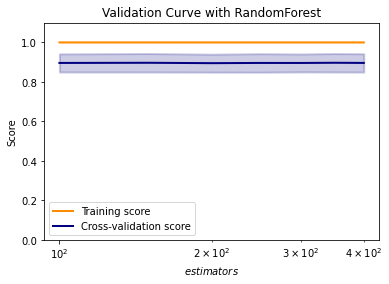

In [36]:
plt.title("Validation Curve with RandomForest")
plt.xlabel(r"$estimators$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(
    param_range,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,
    alpha=0.2,color="darkorange",lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
plt.fill_between(
    param_range,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,
    alpha=0.2,color="navy",lw=lw)

plt.legend(loc="best")
plt.show()

# n_estimator does'nt seem to have any effect on validation data accuracy
# we can tune only those which are effecting the accuracy

# Stacking Random Forest and Gradient Boosting

>RF -38.576 (1.855)
>GB -157.658 (3.147)
>LGB -94.815 (1.921)
>stacking -127.638 (10.585)


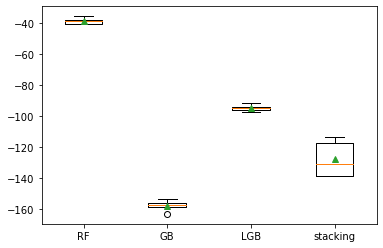

In [5]:
# get a stacking ensemble of models
predictors=['avg_pesq_score', 'quality_too_poor','number_busy', 'temporarily_unable_test', 'outage_sec',
            'numbers_tested', 'followup_tests', 'min_commit', 'has_min_commit','company_type_Conference','company_type_Enterprise', 'number_test_types_1', 'number_test_types_2',
            'number_test_types_3', 'number_test_types_4', 'number_test_types_5','number_test_types_6',
            'is_testing_1', 'Day_of_week_Monday','Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday',
            'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Year_2019','Year_2020', 'Year_2021', 'Month_10', 'Month_11',
            'Month_12', 'Month_2','Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8','Month_9']

x_train=df[predictors].to_numpy()
y_train=df['volume_tests'].to_numpy()


def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('RF', RandomForestRegressor()))
    level0.append(('GB', GradientBoostingRegressor()))
    level0.append(('LGB', HistGradientBoostingRegressor()))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=2)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['RF'] = RandomForestRegressor()
    models['GB'] = GradientBoostingRegressor()
    models['LGB'] = HistGradientBoostingRegressor()
    models['stacking'] = get_stacking()
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model,x_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [ ]:
# Base Random Forest kill all others wow
# we didnt tuned any of the models
# these are just demonstration 

# Stacking pipeline Regression Views

In [4]:
num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']
cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']

outcome=df['volume_tests']

cat_pipe = OneHotEncoder(handle_unknown='ignore')
num_pipe = StandardScaler()

preprocessor =  make_column_transformer(
    (cat_pipe, cat_cols),
    (num_pipe, num_cols))

# Fit a pipeline with transformers and an estimator to the training data
rf_pipeline = make_pipeline(preprocessor, RandomForestRegressor(random_state=0))
gbdt_pipeline = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=0))
hgbdt_pipeline = make_pipeline(preprocessor, HistGradientBoostingRegressor(random_state=0))

estimators = [
    ("Random Forest", rf_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
    ("HistGradient Boosting", hgbdt_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['company_type',
                                                                                  'number_test_types',
                                                                                  'is_testing',
                                                                                  'Day_of_week',
                                                                                  'Year',
                                                                                  'Month']),
                                                                                ('standardscaler',
                                                                                 StandardScaler(),
                                                                                 ['avg_pesq_score',
                                                                                  'quality_too_poor',
                                                                                  'number_busy',
                                                                                  'temporarily_...
                                                                                  'is_testing',
                                                                                  'Day_of_week',
                                                                                  'Year',
                                                                                  'Month']),
                                                                                ('standardscaler',
                                                                                 StandardScaler(),
                                                                                 ['avg_pesq_score',
                                                                                  'quality_too_poor',
                                                                                  'number_busy',
                                                                                  'temporarily_unable_test',
                                                                                  'outage_sec',
                                                                                  'numbers_tested',
                                                                                  'followup_tests',
                                                                                  'min_commit'])])),
                                               ('histgradientboostingregressor',
                                                HistGradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

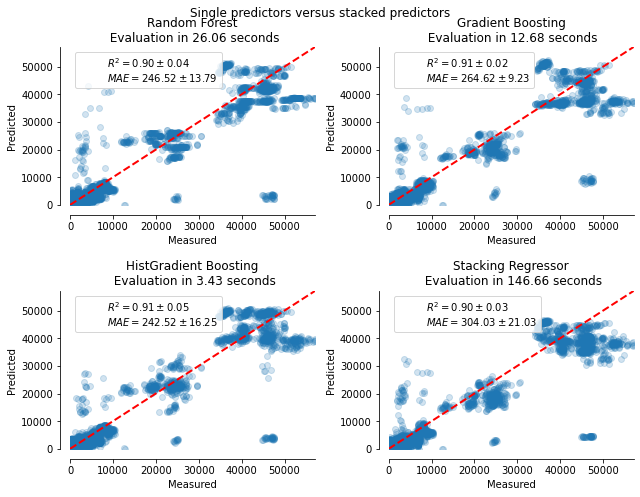

In [28]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [("Stacking Regressor", stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, df, outcome, scoring=["r2", "neg_mean_absolute_error"], n_jobs=-1,cv=2, verbose=0)
    elapsed_time = time.time() - start_time
    y_pred = cross_val_predict(est, df, outcome, n_jobs=-1, verbose=0,cv=2)
    plot_regression_results(
        ax,
        outcome,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Final Prediction Set Random Forest

In [10]:
# we will try to use three scoring method
# R2 , mean absolute Error , mean squared error

scorers = {
    'r2': "r2",
    'mean_absolute_error': make_scorer(mean_absolute_error),
    'mean_squared_error': make_scorer(mean_squared_error)}

num_cols = ['avg_pesq_score','quality_too_poor','number_busy',
            'temporarily_unable_test','outage_sec','numbers_tested',
            'followup_tests','min_commit']

cat_cols=['company_type','number_test_types', 'is_testing','Day_of_week','Year','Month']

outcome=DF_test['volume_tests']
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='error',drop='first'))
])
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
])

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('preprocessor', preprocessor),
   ('model', RandomForestRegressor())
])

# default 5 : generally we do 10 splits with 5 repeats

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_validate(pipe, DF_test, outcome, scoring=scorers, cv=cv, n_jobs=-1,
                       return_train_score=True)


print('Mean R2 Score  : ', np.round(np.mean(scores['test_r2']),3))
print('Std of R2 Score: ', np.round(np.std(scores['test_r2']),3))
print()
print('Losses lower the better')
print()
print('Mean of Root Mean Squared loss:  ', np.round(np.sqrt(np.mean(scores['test_mean_squared_error'])),3))
print('Std of Root Mean Squared loss:   ',np.round(np.sqrt(np.std(scores['test_mean_squared_error'])),3))
print()
print('Mean of Mean Abs loss:   ',np.round(np.mean(scores['test_mean_absolute_error']),3))
print('Std of Mean Abs loss:    ',np.round(np.std(scores['test_mean_absolute_error']),3))

Mean R2 Score  :  0.992
Std of R2 Score:  0.005

Losses lower the better

Mean of Root Mean Squared loss:   312.743
Std of Root Mean Squared loss:    206.263

Mean of Mean Abs loss:    71.363
Std of Mean Abs loss:     5.819


In [11]:
# we can do influence analysis on value 
# If this was classification we would have done post hoc anaylysis which classifications were wrong
# we would have done calibration also for non linear models.